# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [472]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import numpy as np
# !pip install missingno
# import missingno as msno

In [224]:
data=pd.read_csv('real_estate_data.csv', sep='\t')

In [225]:
print(data.info()) #общая информация 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

В таблице много пропусков, также неверный формат в столбцах с датами, количеством этажей, балконов, столбец is_apartment должен быть логическим

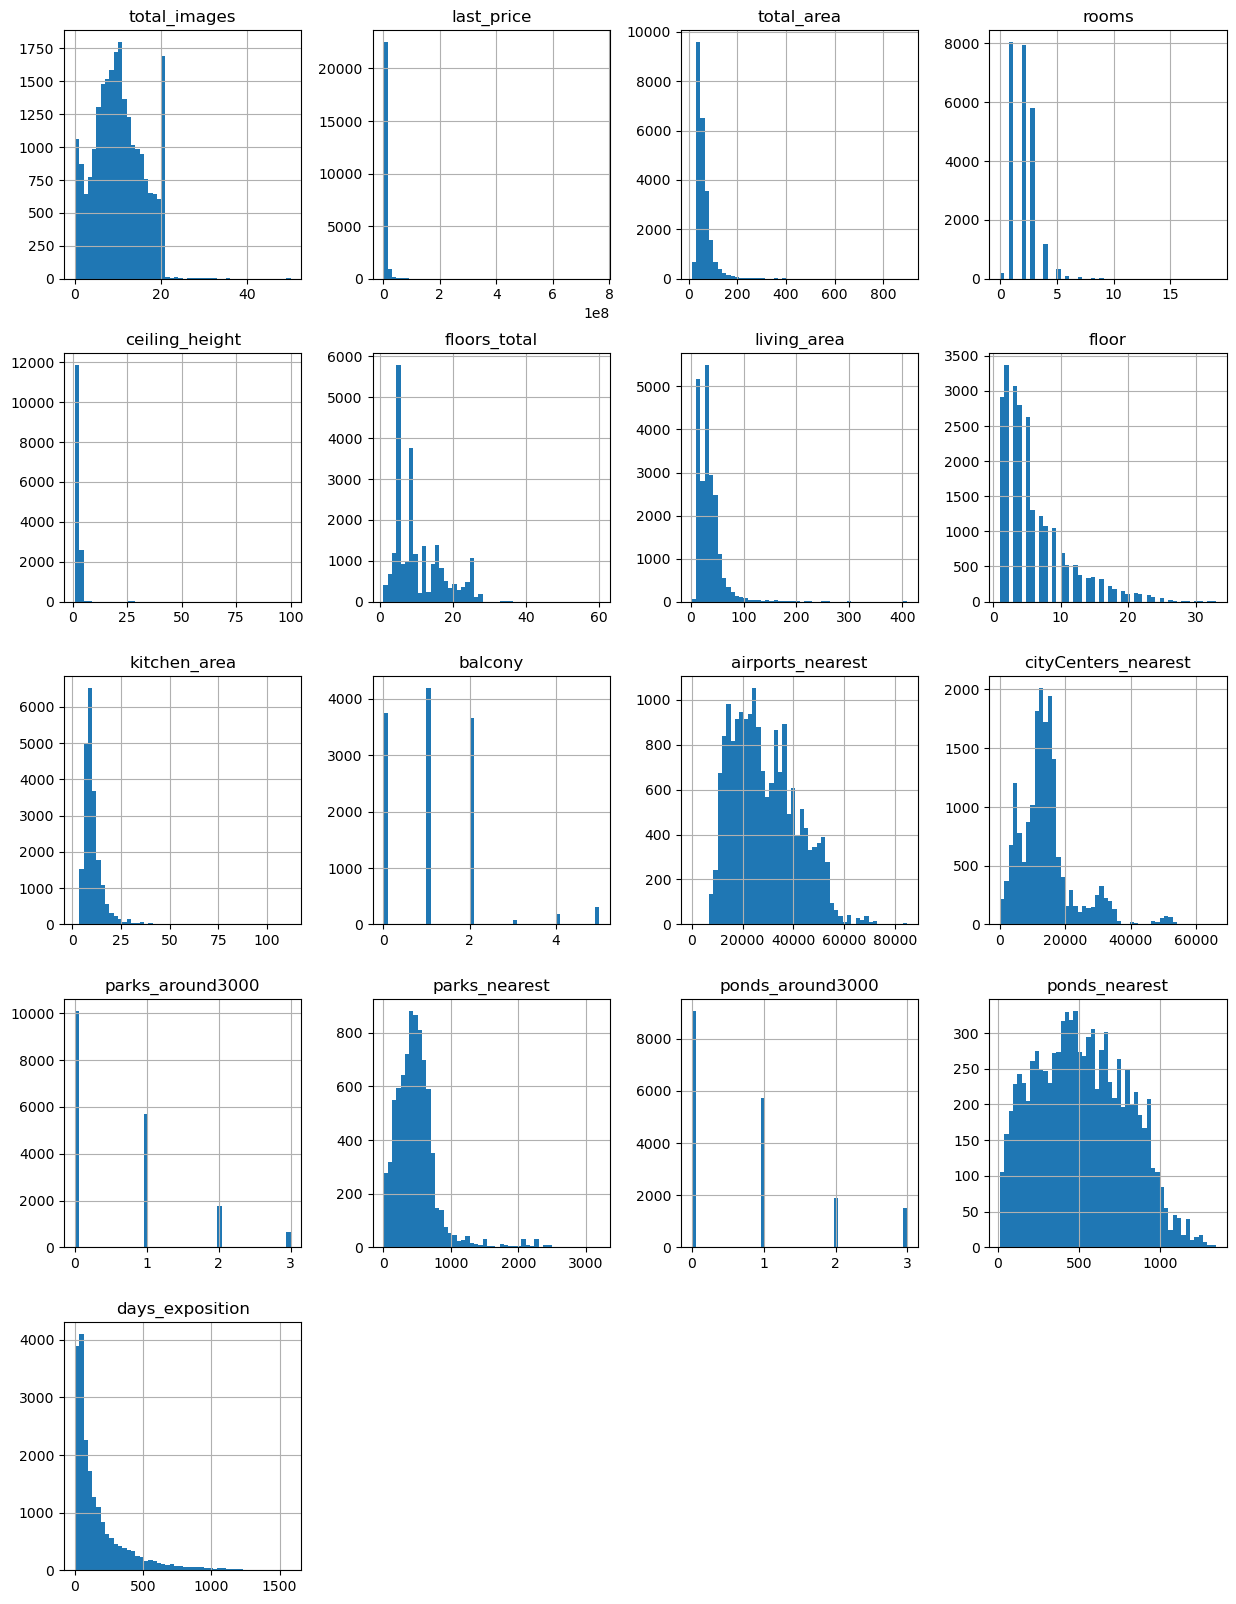

In [226]:
# Рассмотрим распределение данных по столбцам
data.hist(bins=50, figsize=(15, 20)) #вывод диаграмм по показателям
plt.show()

- количество фотографий для большинства объявлений укладывается в дипазон до 20 штук
- пик цены сконцентрирован в узкой области, что указывает на наличие аномально высоких цен, выбивающихся из общей выборки
- основная доля квартир укладывается в площадь до 160кв.м, есть также узкое распределение в начале оси, есть квартиры с аномально большой площадью
- основная доля квартир имеет до 5 комнат, но есть объявления с 10-ю и более 
- высота потолка в большинстве квартир до 5 метров, но есть выбивающиеся значения с более высокими потолками
- большая часть квартир располагается в домах с этажами до 30, но есть обявления в домах с более высокой этажностью. Есть выдающиеся пики, соответствующие 5-7 этажам 
- основная часть квартир укладывается в диапазон до 80 кв.м., есть редкие квартиры с более высокими значениями 
- большинство квартир расположены не выше 20 этажа, что соответствует распределению по общему количеству этажей
- большиство кухонь имеет площадь до 20 кв.м., есть выбивающиеся более высокие значения
- количество балконов в основном до 2
- данные о расстоянии от центра, аэропорты, парка, пруда шумные, много выделяющихся пиков
- большинство обявлений были размещены до 600 дней
- гистограммы соответствуют нормальному распределению Гаусса, есть выделяющиеся пики, но это объясняется особенностью анализируемых данных

### Предобработка данных

In [227]:
#переименуем столбец в сооответствии со стандартом
data.rename(columns={'cityCenters_nearest' : 'city_centers_nearest'}, inplace=True) 

In [228]:
#оценим пропсуки в столбцах
data.isna().mean() 

total_images            0.000000
last_price              0.000000
total_area              0.000000
first_day_exposition    0.000000
rooms                   0.000000
ceiling_height          0.387991
floors_total            0.003629
living_area             0.080299
floor                   0.000000
is_apartment            0.882906
studio                  0.000000
open_plan               0.000000
kitchen_area            0.096122
balcony                 0.486054
locality_name           0.002068
airports_nearest        0.233850
city_centers_nearest    0.232879
parks_around3000        0.232837
parks_nearest           0.659100
ponds_around3000        0.232837
ponds_nearest           0.615596
days_exposition         0.134225
dtype: float64

*Наибольшее количество пропусков в столбце с типом апартаменты. Также много пропусков в столбце с наличием балконов, парков и прудов* 

In [229]:
# # Рассмотрим взаимосвязь пропусков
# msno.matrix(places)
# plt.show()

**Анализ пропусков**


Пропуски в столбцах, формируемые пользователями, могут быть связаны:
- С необязательностью заполнения информации, пользователь сам принимает решение об их заполнении:
- Если пользователь считает данную информацию неважной для продажи квартиры, эти ячейки пропускаются 
- Информация по высоте потолков, жилой площади, площади кухни требует от пользователя отдельного уточнения информации, которая не всегда есть в быстром доступе при формирования объявления
- Большинство значений с столбце **"is_apartment"** скорее всего пропущены, потому что данный тип планировки появился позднее
- Если парк или пруд дальше 3 км, значения пропускались
- Был установлен максимальный радиус поиска или дипазоны поиска, за пределами которых, данные не собирались 


#### Обработка пропусков


In [230]:
#пропуски в данном столбце соответствуют другому типу планировок
data['is_apartment'] = data['is_apartment'].fillna('False') 
 #пропуски в данном столбце соответствуют отсутствию балконов
data['balcony']=data['balcony'].fillna(0)
#пропуски в данном столбце, скорее всего, соответствуют отсутствию парков в радиусе 3 км, показатель не сильно значимый
data['parks_around3000']=data['parks_around3000'].fillna(0) 
#пропуски в данном столбце соответствуют отсутствию прудов в радиусе 3 км, показатель не сильно значимый 
data['ponds_around3000']=data['ponds_around3000'].fillna(0)
print('количество пропусков в is_apartment:', data['is_apartment'].isna().sum())
print('количество пропусков в parks_around3000:', data['parks_around3000'].isna().sum())
print('количество пропусков в ponds_around3000:', data['ponds_around3000'].isna().sum())

количество пропусков в is_apartment: 0
количество пропусков в parks_around3000: 0
количество пропусков в ponds_around3000: 0


In [231]:
# найдем медианное отношение жилой площади к общей
ratio=data['living_area'].median()/data['total_area'].median()
#используем полученный коэффициент для вычисления площади в строках с пропусками
data['living_area'].isna().sum()
#заполним пропуски
data['living_area']=data['living_area'].fillna(ratio*data['total_area']) 
print('количество пропусков в living_area:',data['living_area'].isna().sum())

количество пропусков в living_area: 0


In [232]:
# найдем среднее отношение площади кухни к общей площади 
ratio=data['kitchen_area'].median()/data['total_area'].median()
# найдем расчетную площадь кухни
kitchen_area_calc=ratio*data['total_area']
# найдем сумму площадей кухни и жилой области, данное значение должны быть меньше общей площади, для расчета возьмем коэф 0,95 
total_area=kitchen_area_calc+data['living_area']
# Найдем строки, в которых данное условие соблюдается и которые являются квартирами
rows=(data['total_area']*0.95>total_area)&(data['kitchen_area'].isna())&(data['studio']==False)
# Заменим пропущенные значения в строках, где выполняется заданное условие
data.loc[rows, 'kitchen_area']=data['kitchen_area'].fillna(kitchen_area_calc)
print('количество пропусков в kitchen_area:', data['kitchen_area'].isna().sum())

количество пропусков в kitchen_area: 202


In [233]:
# удалим строки, в которых данное условие не соблюдается, так как данные в таких объявлениях некорректны
data.dropna(subset=['kitchen_area'], inplace=True)
print('количество пропусков в kitchen_area:', data['kitchen_area'].isna().sum())

количество пропусков в kitchen_area: 0


In [234]:
# Найдем расстояние до центра для строк с прощенными названиями и установим, каким городам они соответствуют
location=data.loc[data['locality_name'].isna(), 'city_centers_nearest'].unique()
(
    data
    .query('city_centers_nearest in @location')
    .pivot_table(index='locality_name', values='city_centers_nearest', aggfunc=['min', 'max'])

)

,min,max
,city_centers_nearest,city_centers_nearest
locality_name,,
Санкт-Петербург,1322.0,17369.0
посёлок Шушары,17369.0,17369.0


In [235]:
#Заменим значения на Санкт-Петурбург, большинство строк в этом расстоянии попадает под него
data['locality_name']=data['locality_name'].fillna('Санкт-Петербург')
print('количество пропусков в locality_name:', data['locality_name'].isna().sum())

количество пропусков в locality_name: 0


In [236]:
#Заменим пропущенные строки в высоте потолков медианным значением, так как этот параметр не является важным при формировании цены
data['ceiling_height']=data['ceiling_height'].fillna(data['ceiling_height'].median())
print('количество пропусков в ceiling_height:', data['ceiling_height'].isna().sum())

количество пропусков в ceiling_height: 0


In [237]:
floors_row=(data['floors_total'].isna())&(data['floors_total'].mean()>=data['floor'])
data.loc[floors_row, 'floors_total']=data['floors_total'].fillna(data['floors_total'].mean())
print('количество пропусков в floors_total:', data['floors_total'].isna().sum())
#остальные строки с пропусками оставим, так как они не влияют на дальнейший расчет

количество пропусков в floors_total: 32


In [238]:
# Найдем уникальные значения в названии населенных пунктов
# Заменим букву е на ё, исключим дополнения к названиям поселков (городской, городского) 
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
#Приведем к нижнему регситру
data['locality_name'] = data['locality_name'].str.lower()
data['locality_name'] = data['locality_name'].str.replace('городской поселок','поселок городского типа')
print('количество уникальных значений в locality_name:',len(data['locality_name'].unique()))

количество уникальных значений в locality_name: 322


In [239]:
#найдем какое среднее расстояние соответсвует названиям населенных пунктов, заменим пропущенные значения на среднее расстояние
for name in data['locality_name'].unique():
    data.loc[(data['locality_name']==name)&(data['airports_nearest'].isna()),'airports_nearest']=\
    data.loc[data['locality_name']==name, 'airports_nearest'].mean()
data['airports_nearest'].isna().sum()

4820

In [240]:
#найдем какое среднее расстояние соответсвует названиям населенных пунктов, заменим пропущенные значения на среднее расстояние
for name in data['locality_name'].unique():
    data.loc[(data['locality_name']==name)&(data['city_centers_nearest'].isna()),'city_centers_nearest']=\
    data.loc[(data['locality_name']==name), 'city_centers_nearest'].mean()
data['city_centers_nearest'].isna().sum()

4820

In [241]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               32
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         4820
city_centers_nearest     4820
parks_around3000            0
parks_nearest           15456
ponds_around3000            0
ponds_nearest           14464
days_exposition          3161
dtype: int64

Пропущенные значения остались к столбцах:
- floors_total
- airports_nearest 
- city_centers_nearest
- parks_nearest 
- ponds_nearest
- ponds_nearest
- days_exposition


*Скорее всего, невозможно оценить, чем могут быть заменены данные параметры, так как они являются независимыми от других факторов, поэтому оставим пропуски в данных столбцах*

#### замена формата данных
- first_day_exposition - зададим тип данных для дальнейшей работой со значениями
- is_apartment - заменим на булев тип, так как он занимает меньший объем
- floors_total balcony, parks_around3000, ponds_around3000, days_exposition - заменим на int, занимают меньший объем 

In [242]:
data['first_day_exposition']=pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['first_day_exposition']=data['first_day_exposition'].round('1d')

In [243]:
col_to_change=['floor','floors_total', 'balcony', 'parks_around3000', 'ponds_around3000','days_exposition']
for col in col_to_change:
    data[col]=data[col].astype('int32', errors='ignore')

In [244]:
data['is_apartment']=data['is_apartment'].astype('bool')

#### поиск аномальных значений

In [245]:
#Оценим общую таблицу с характерными значениями

data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23497.000000,2.349700e+04,23497.000000,23497.000000,23497.000000,23465.000000,23497.000000,23497.000000,23497.000000,23497.000000,18677.000000,18677.000000,23497.000000,8041.000000,23497.000000,9033.000000,20336.000000
mean,9.874920,6.559105e+06,60.577592,2.084053,2.724267,10.633723,34.704050,5.875473,10.545083,0.588756,29499.465481,14439.908981,0.470741,490.627658,0.591139,517.995129,181.384687
std,5.684741,1.088129e+07,35.641273,1.067819,0.992193,6.568331,22.349551,4.871221,6.035705,0.958696,13017.504579,8611.410310,0.749308,342.306197,0.884337,277.704589,220.070123
min,0.000000,1.219000e+04,13.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.450000e+06,40.100000,1.000000,2.600000,5.000000,19.000000,2.000000,7.000000,0.000000,18849.000000,9467.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.010000,0.000000,27357.000000,13252.000000,0.000000,455.000000,0.000000,502.000000,96.000000
75%,14.000000,6.800000e+06,70.000000,3.000000,2.700000,16.000000,42.200000,8.000000,12.000000,1.000000,38426.000000,16722.000000,1.000000,612.000000,1.000000,730.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


*В данных встречаются объявления с ценой от 12 тысяч до 763 млн. рублей, площадью от 13 до 900 кв.м, высотой потолков от 1 до 100 метров, кухнями от 1.3 до 100 кв.м. Как видим, в изначальных данных много аномальных значений, оценим каждый по порядку* 

**Анализ цен** 

Для более наглядного поиска выбросов построим диаграмму размаха. 

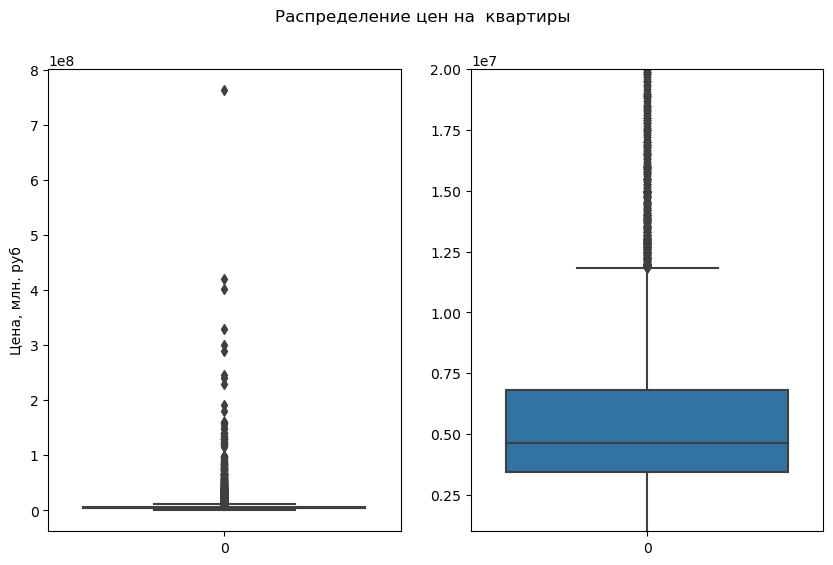

In [246]:
# Рассмотрим диапозон цен
fig=plt.figure(figsize=(10,6))
ax1=fig.add_subplot(1,2,1)
sns.boxplot(data=data['last_price'], ax=ax1)
# Иключим выбросы для более подробной оценки распределения цен
ax2=fig.add_subplot(1,2,2)
sns.boxplot(data=data['last_price'], ax=ax2)
ax1.set_ylabel('Цена, млн. руб')
ax2.set_ylim(1000000, 20000000)
plt.suptitle('Распределение цен на  квартиры')
plt.show()

Из графика видим,что значения за пределами 4.0e7 являются редкими выбросами, 99% данных попадает в этот диапазон. 50% результатов попадает в диапозон до 500000. 
Исключим значения выше 4.0e7. Также есть аномально низкая цена за квартиру 12190, что точно является ошибкой. Исключим данные значения и перезапишем таблицу.  

In [247]:
print('доля объявлений дешевле, чем 40 млн:', round((data['last_price']<4.0e7).mean(),2))

доля объявлений дешевле, чем 40 млн: 0.99


In [248]:
# перезапишем таблицу
data_new=data[(data['last_price']<4.0e7)&(data['last_price']>1.219e4)]

**Анализ площадей**

Для более наглядного поиска выбросов построим гистограммы для общей площади, кухни и жилой площади

In [417]:
# Зададим функцию для построения распредееления данных
def plt_hist(data, values, limit, bins, xlabel, title):
    data.hist(values, figsize=(10,5), range=limit, bins=bins, color='coral')
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

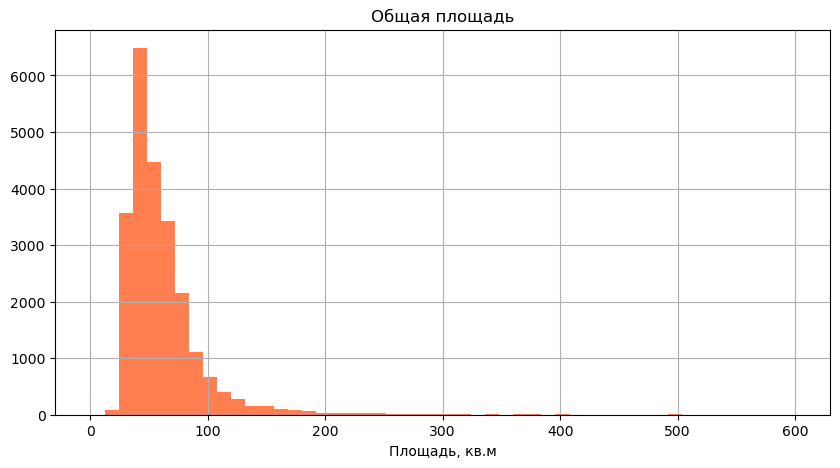

In [315]:
plt_hist(data, 'total_area', (0,600), 50, 'Площадь, кв.м', 'Общая площадь')

- *Из графика видно, что значения больше 400 м практически отсутсвуют. Диапазон до 400м покрывает более 99% данных, остальные значения исключим и перезапишем таблицу*
- *Наибольшее количество квартир имеют площадь около 50 кв.м.*
- *есть квартиры меньше 20 метров, данные квартиры предлагается оставить, так как эта площадь близка к среднему значению и не сильно влияет на разброс данных*

In [250]:
print('доля квартир меньше 400 кв.м.:', round((data_new['total_area']<400).mean(),5))

доля квартир меньше 400 кв.м.: 0.99979


In [251]:
data_new=data_new[data_new['total_area']<400]

In [252]:
# найдем сумму площадей кухни и жилой области, данное значение должно быть меньше общей площади, для расчета возьмем коэф 0,95 
print('ошибок в соотношении площадей:',
      len(data_new[(data_new['kitchen_area']+data_new['living_area'])>(0.95*data_new['total_area'])]))

ошибок в соотношении площадей: 244


In [253]:
# доля таких объявлений составляет 1%, исключим их из выборки, так как данные в них некорректны 
print('доля ошибок в соотношении площадей:',
      round(((data_new['kitchen_area']+data_new['living_area'])>(0.95*data_new['total_area'])).mean(),6))

доля ошибок в соотношении площадей: 0.010473


In [ ]:
# исключим ошибочные значения из выборки
data_new=data_new[(data_new['kitchen_area']+data_new['living_area'])<(0.95*data_new['total_area'])]

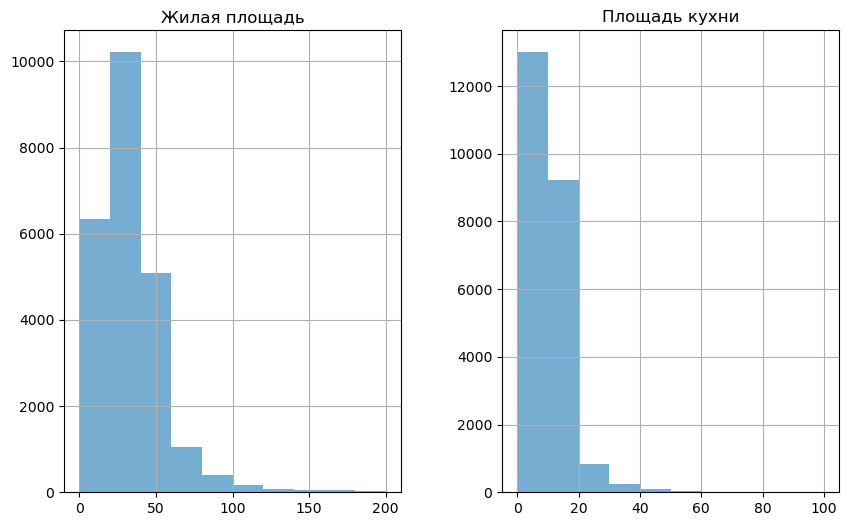

In [267]:
#Посторим гистограммы для жилой площади и плошади кухни. 
# Так как мы удалили квартиры с аномально большой ценой и площадью, кухни и жилые помещения оценим по минимальным значениям.
fig=plt.figure(figsize=(10,6))
ax1=fig.add_subplot(1,2,1)
data.hist('living_area',  range=(0,200), ax=ax1, alpha=0.6)
ax2=fig.add_subplot(1,2,2)
data.hist('kitchen_area', range=(0,100), ax=ax2, alpha=0.6)
ax1.set_title('Жилая площадь')
ax2.set_title('Площадь кухни')
plt.show()

- Из гистограммы видно, что есть квартиры с жилой площадью около нуля
- Основной объм выборки имеет жилую площадь до 100 кв.м.
-  Основной объм выборки имеет площадь кухни до 40 кв.м.

*Рассмотрим подробнее квартиры  жилой площадью около нуля*

In [272]:
# Рассмотрим, какова общая площадь таких квартир
(
    data_new
    .query('living_area<10')
    .pivot_table(index='living_area', values='total_area', aggfunc='mean').reset_index()
)

,living_area,total_area
0,6.500000,33.000000
1,7.500000,13.000000
2,7.615385,13.200000
3,8.000000,43.800000
4,8.300000,21.400000
5,8.400000,62.400000
6,8.500000,35.300000
7,8.653846,15.000000
8,8.900000,33.000000
9,9.000000,36.688889


In [ ]:
#В квартирах с жилой площадью до 5 кв.м неадекватное соотношение жилой площади к общей, скорее всего, это ошибки в объвлении, 
# данные до 5 кв.м предлагаю исключить

In [268]:
data_new=data_new[data_new['living_area']>6]

,total_area
living_area,
2.000000,52.0
3.000000,41.0
5.400000,77.6
6.000000,31.0
6.500000,33.0
7.500000,"[13.0, 13.0]"
7.615385,13.2
8.000000,"[50.6, 37.0]"
8.300000,21.4


In [271]:
# Рассмотрим площади квартир с кухнями до 3 кв.м.
(
    data_new
    .query('kitchen_area<3')
    .pivot_table(index='kitchen_area', values='total_area', aggfunc='mean').reset_index()
)


,kitchen_area,total_area
0,1.300,28.500000
1,2.000,23.712857
2,2.275,13.000000
3,2.300,34.700000
4,2.310,13.200000
5,2.400,18.400000
6,2.625,15.000000
7,2.890,66.400000


In [ ]:
#Есть кухня с неадекватным значением 1,3 кв.м.
# В остальных случаях небольшая площадь кухни соотносится с общей площадью, скорее всего, данные корректные
data_new=data_new[data_new['kitchen_area']>1.3]

**Анализ высоты потолков**

In [187]:
print(data_new['ceiling_height'].describe()) # Посмотрим максимальную и минимальную высоту

count    23047.000000
mean         2.714175
std          0.731669
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         32.000000
Name: ceiling_height, dtype: float64


In [ ]:
# Есть потолки 1 метр и 32, ошибка в формате данных, разделим значения выше 25 метров и оставим потолки больше 2,5 и меньше 5 м 
data_new.loc[data_new['ceiling_height']>25,'ceiling_height']=data_new['ceiling_height']/10
data_new=data_new[((data_new['ceiling_height']<=5)&(data_new['ceiling_height']>=2.5))|(data_new['ceiling_height'].isna())]

**Анализ этажей**

In [188]:
print(data_new['floors_total'].describe()) # Посмотрим максимальные и минимальные значения


count    22926.000000
mean        10.670535
std          6.575256
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64
Количество этажей больше 37: 2
Этаж больше общего количества этажей: 0


In [273]:
print('Количество этажей больше 37:', (data_new['floors_total']>37).sum())#максимальная этажность в Санкт-Петербуреге - 37 этажей
print('Этаж больше общего количества этажей:', (data_new['floor']>data_new['floors_total']).sum())
# Предлагается оставить эти данные, этажность не является важным фактором, влияющим на цену  

Количество этажей больше 37: 2
Этаж больше общего количества этажей: 0


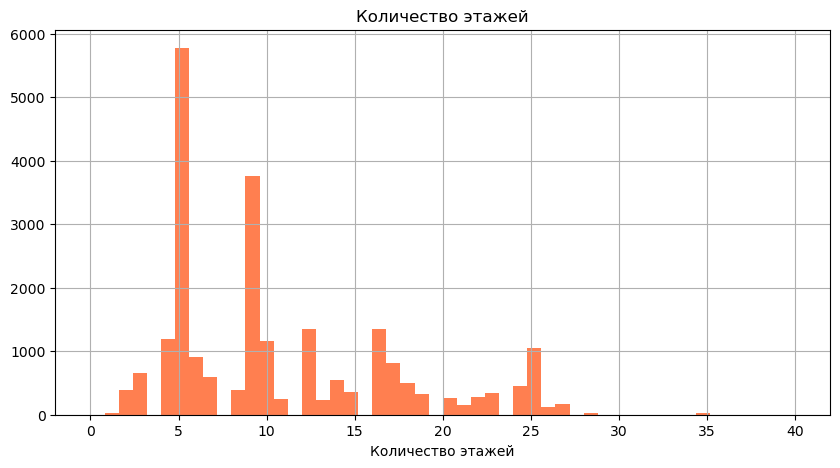

In [316]:
# Построим распределение количества этажей
plt_hist(data, 'floors_total', (0,40), 50, 'Количество этажей', 'Количество этажей')

Из полученного графика видим, что наиболее часто встречаютя дома с 6 и 9 этажами, дома с этажами более 25 - отдельные выбросы

**Анализ длительности размещения объявлений** 

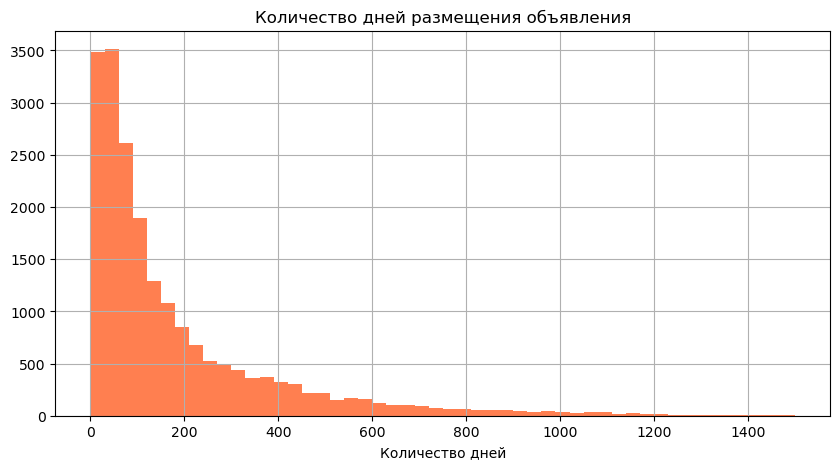

In [318]:
# Построим распределение дней размещения объявления
plt_hist(data,'days_exposition', (0,1500), 50, 'Количество дней', 'Количество дней размещения объявления')

- при изменении границ гистограммы видно, что большой объем значений попадает в диапазон до недели 
- есть объявления больше 3-лет. Скорее всего данные квартиры не были проданы, нужна дополнительная информация по данному параметру для оценки адекватности значений

In [290]:
print(data_new['days_exposition'].describe())

count    20179.000000
mean       180.340552
std        219.210952
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64


**Анализ количества комнат**

In [293]:
# Посмотрим распределение значений
print(data_new['rooms'].describe()) 

count    23295.000000
mean         2.064349
std          1.036812
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64


In [294]:
# Есть объявления с 0 комнатами, проверим, что такие объявления не относятся к апартаментам и студии
print('квартиры без комнат:', len(data_new.loc[(data_new['rooms']==0)&(~data_new['is_apartment'])]))

квартиры без комнат: 1


*Квартирами без комнат являются студии и квартиры с открытой планировкой*

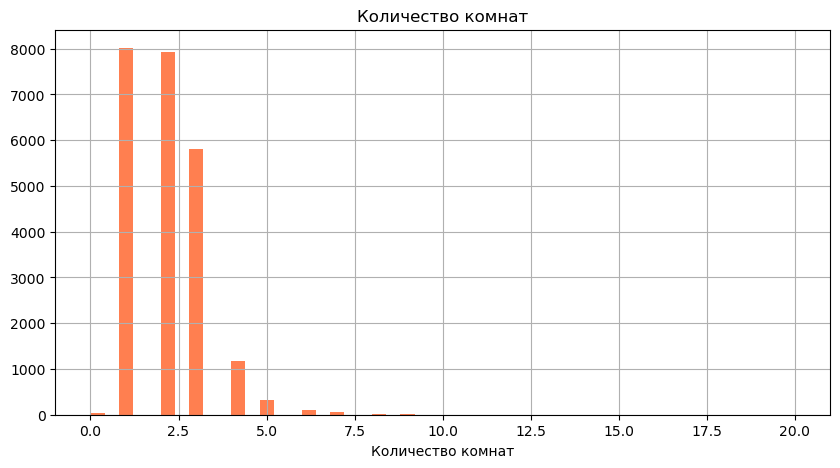

In [320]:
# Рассмотрим распределение количества комнат в квартирах
plt_hist(data,'rooms', (0,20), 50, 'Количество комнат', 'Количество комнат')
 

In [300]:
#количество квартир с комнатами выше 7 мало, исключим эти значения
data_new=data_new[data_new['rooms']<=7] 

**Анализ расстояний до парка, центра, пруда, аэоропорта нецелесообразен, так как там могут быть любые значения**


В результате предобработки данных были исключены объвления:
- пустые ячейки заменили нулевыми значениями там, где это было возможно (количество балконов, парков, прудов)
- пустые ячейки в площади кухни и жилой площади заменили средними значеними, при условии, что их сумма не больше заданной, строки, не соответстующие данному условию удалили
- строки с пустыми значениями общего количества этажей были удалены, для корректных расчетов в последующем анализе
- для заполнения пропусков в населенных пунктах были вычислены названия населенных пунктов по расстоянию от центра по названию населенного пункта были вычислены средние значения расстояний до центра и аэропорта и заполнены пропущенные значения там, где данные были представлены
- с аномально высокой ценой (>40 млн) и площадью(>400 кв.м): данные квартиры относятся к элитной недвижимости, но их выборка очень мала для адекватного анализа
- маленькой жилой площадью(<5 кв.м): в таких квартирах общая площадь была намного выше жилой, что, скорее всего указывает на некорректность размещенных данных) и кухней (<1.3 кв.м): такая площадь нереальна для кухни 
- очень высокими потолками (>5 м): максимальная высота потолков в жилых помещения Санкт-Петербурге 5 м, судя по данным из открытых источников, и низкими потолками (<2.5 м): ниже значения не разрешены по санитарным нормам
- с большим количеством комнат (>7), также относятся к элитной недвижимостью
- с суммой площади кухни и жилой зоны больше общей: в таких объявлениях, скорее всего, указаны некорректные данные

Доля исключенных значений составляет около 2%.  

In [192]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22935 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22935 non-null  int64         
 1   last_price            22935 non-null  float64       
 2   total_area            22935 non-null  float64       
 3   first_day_exposition  22935 non-null  datetime64[ns]
 4   rooms                 22935 non-null  int64         
 5   ceiling_height        22935 non-null  float64       
 6   floors_total          22903 non-null  float64       
 7   living_area           22935 non-null  float64       
 8   floor                 22935 non-null  int32         
 9   is_apartment          22935 non-null  bool          
 10  studio                22935 non-null  bool          
 11  open_plan             22935 non-null  bool          
 12  kitchen_area          22935 non-null  float64       
 13  balcony         

### Посчитайте и добавьте в таблицу новые столбцы

In [412]:
data_new['sqr']=round(data_new['last_price']/data_new['total_area'], 2) #вычислим цену за квадратный метр
data_new['day']=data_new['first_day_exposition'].dt.day_name() #вычислим день размещения объявления
data_new['month']=data_new['first_day_exposition'].dt.month #вычислим месяц размещения объявления
data_new['year']=data_new['first_day_exposition'].dt.year #вычислим год размещения объявления

In [399]:
data_new['parks_nearest'].describe()

count    7869.000000
mean      492.610497
std       342.805632
min         1.000000
25%       289.000000
50%       456.000000
75%       613.000000
max      3190.000000
Name: parks_nearest, dtype: float64

In [380]:
# разобъем этажи по категориям
def floor_category(row):
    floor=row['floor']
    floor_max=row['floors_total']
    if floor==1:
        return 'первый'            
    elif floor==floor_max:
        return 'последний'
    else:
        return 'другой'
data_new['floor_category']=data_new.apply(floor_category, axis=1)

In [400]:
 #вычислим расстояние до центра в км
data_new['city_center']=round(data['city_centers_nearest']/1000, 0)
data_new['airports_nearest']=round(data['airports_nearest']/1000, 0)

### Проведите исследовательский анализ данных

#### Изучение параметров объектов
Так как основная доля квартир приходится на Санкт-Петербург, предлагаю рассмотреть данные для города и области по отдельности, для выявления различий в распределении данных 

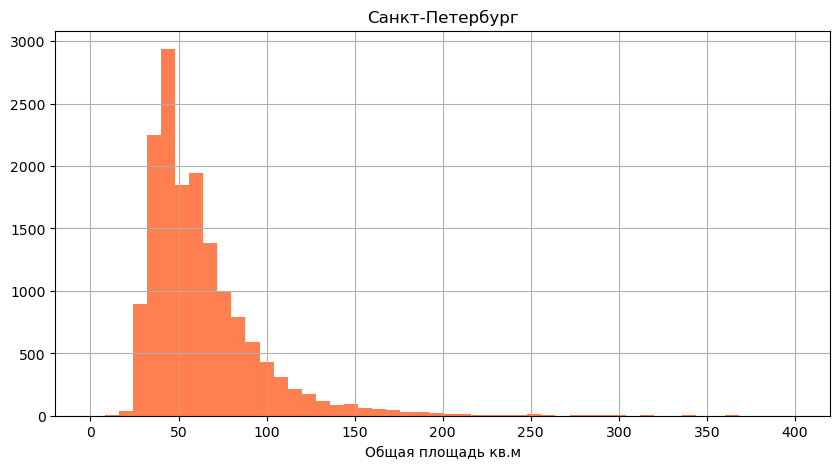

In [327]:
# Построим распределение площади по Санкт-Петербургу
plt_hist(data_new.query('locality_name == "санкт-петербург"'), 'total_area', (0,400), 50, \
         'Общая площадь кв.м', 'Санкт-Петербург')

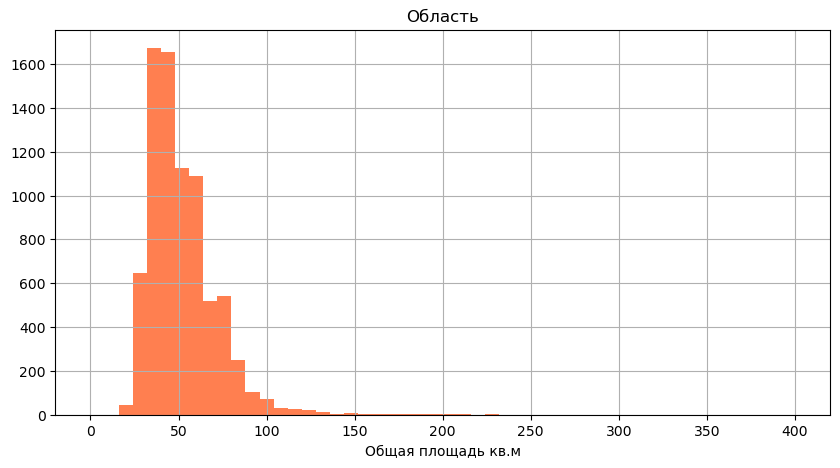

In [329]:
Построим распределение площа
plt_hist(data_new.query('locality_name != "санкт-петербург"'), 'total_area', (0,400), 50, 'Общая площадь кв.м', 'Область')

- *На гистограмме общей площади для Санкт-Петербурга основной широкий пик представлен в диапазоне от 30 до 70 кв.м, наиболее часто встречаются квартиры около 50 кв.м  Основной объем выборки укладывается в значения примерно до 170 кв.м., после этого значений мало, после 200 кв.м. практически не встречаются, однако есть отдельные выбросы*
- *На гистограмме общей площади для области основной широкий пик представлен в диапазоне от 30 до 60 кв.м, наиболее часто встречаются квартиры около 40 кв.м  Основной объем выборки укладывается в значения примерно до 120 кв.м., после этого значений мало, после 150 кв.м. значения практически не встречаются, однако есть отдельные выбросы*


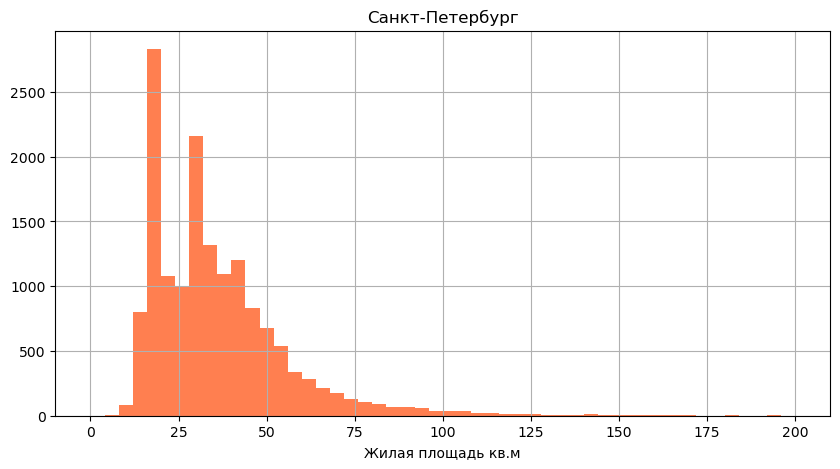

In [340]:
# Построим распределение жилой площади по Санкт-Петербургу
plt_hist(data_new.query('locality_name == "санкт-петербург"'), 'living_area', (0,200), 50, \
         'Жилая площадь кв.м', 'Санкт-Петербург')

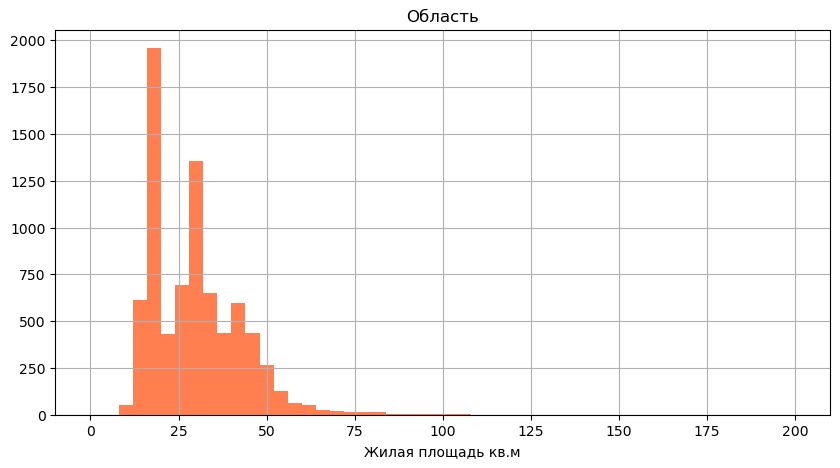

In [341]:
# Построим распределение жилой площади по области
plt_hist(data_new.query('locality_name != "санкт-петербург"'), 'living_area', (0,200), 50, \
         'Жилая площадь кв.м', 'Область')

- *На гистограммах несколько узких пиков в районе около 15 и 30 кв.м, возможно, это связано с особенностями планировок квартир в Ленинградской области, распределение неравномерное, но в целом адекватное* 
- *Основная часть выборки в Санкт-Петербурге попадает в диапазон до 100 кв.м. Значения выше 150 кв.м практически отсутствуют*
- *В области широкий пик в области 10-30 кв.м, наиболее часто встречаются квартиры с жилой площадью около 20 кв.м, основная часть выборки попадает в диапазон до 75 кв.м, значения выше 100 кв.м. практически не встречаются*  


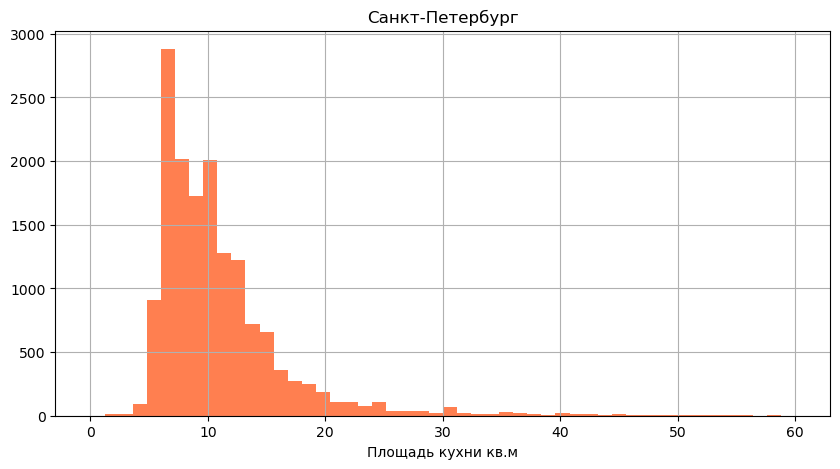

In [342]:
# Построим распределение жилой площади по Санкт-Петербургу
plt_hist(data_new.query('locality_name == "санкт-петербург"'), 'kitchen_area', (0,60), 50, \
         'Площадь кухни кв.м', 'Санкт-Петербург')

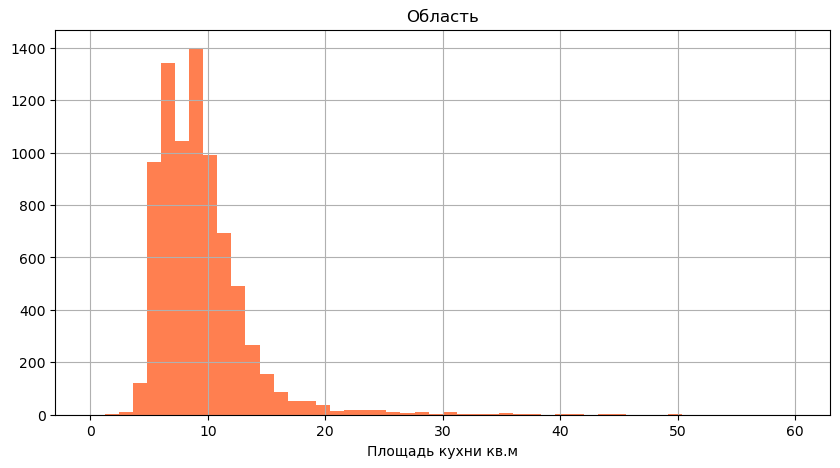

In [343]:
# Построим распределение жилой площади по Санкт-Петербургу
plt_hist(data_new.query('locality_name != "санкт-петербург"'), 'kitchen_area', (0,60), 50, \
         'Площадь кухни кв.м', 'Область')

- *наиболее часто встречюатся кухни с площадью около 6 кв.м, в области также часто встречаются квартиры с кухнями 8 кв.м*
- *в Санкт-Петербурге основной объем выборки укладывается до 30 кв.м, при этом встречаются отдельные значения до 50 кв.м, после чего значений практически нет*
- *в области основной объем данных укладывается до 20 кв.м, затем встречаются редкие отдельные выбросы*

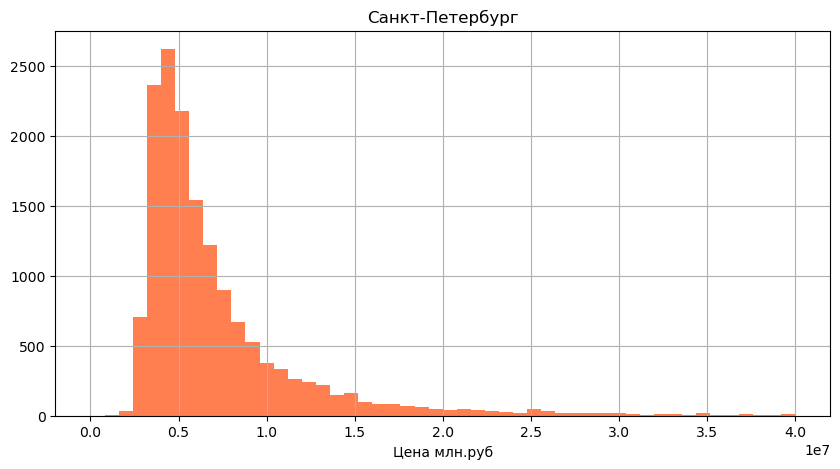

In [346]:
plt_hist(data_new.query('locality_name == "санкт-петербург"'), 'last_price', (0,40000000), 50, \
         'Цена млн.руб', 'Санкт-Петербург')

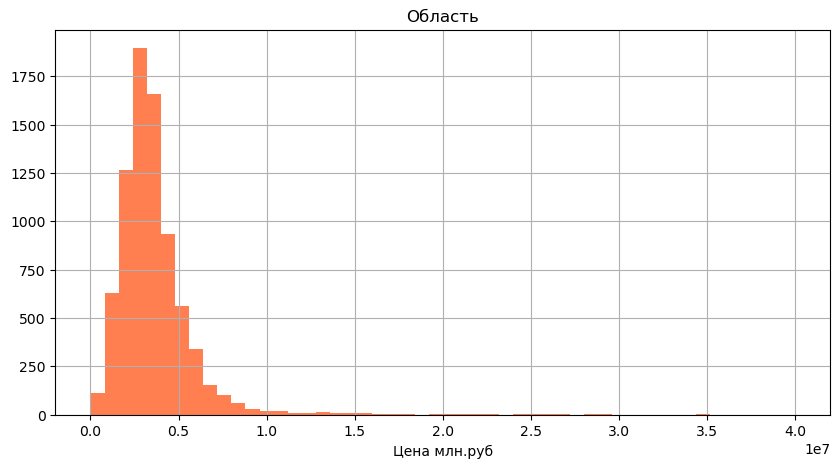

In [348]:
plt_hist(data_new.query('locality_name != "санкт-петербург"'), 'last_price', (0,40000000), 50, \
         'Цена млн.руб', 'Область')

- *Ожидаемо наиболее сильную разницу между областью и Санкт-Петербургом в распределении значений демонстириует цена*
- *Для области наиболее высокий пик в районе 2,5-3,5 млн руб, для Санкт-Петербурга 4-6 млн* 
- *В области наибольшее количество объявлений попадает в дипазон до 10 млн руб, тогда как в Санкт-Петербурге этот дипазон составляет около 20 млн*


In [368]:
# Зададим функцию для построения графиков распределения
def get_value(data, param, func, title, xlabel):
    params=data.groupby(param).agg(value=(param, func))
    params.plot(kind='bar', alpha=0.6, legend=False)
    plt.title(title)
    plt.xlabel(xlabel)

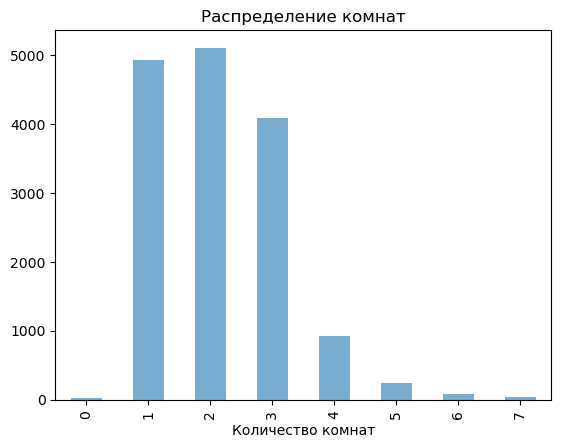

In [369]:
get_value(data_new.query('locality_name == "санкт-петербург"'), 'rooms', 'count', 'Санкт-Петербург', 'Количество комнат')

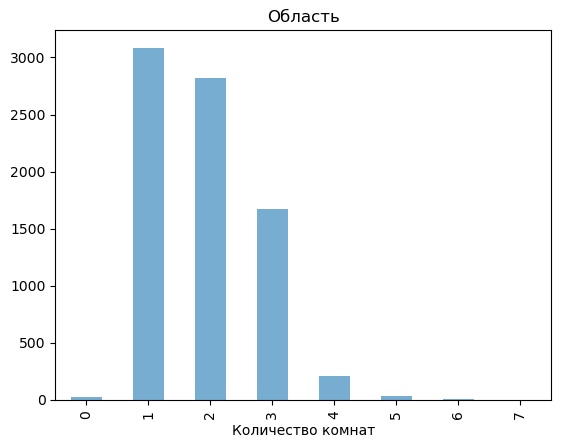

In [371]:
get_value(data_new.query('locality_name != "санкт-петербург"'), 'rooms', 'count', 'Область', 'Количество комнат')

- *В области доля 1-х квартир выше чем 2-х комнатных*
- *В Санкт-Петербурге больше 2-х комнатных квартир и доля 3-х комнатных квартир в общей выборке выше, чем в области*



*Для показателей "высота потолка", "этаж", "категория этажа" не ожидается важных отличий между областью и Санкт-Петербургом, поэтому продолжим исследование данных по общей выборке* 

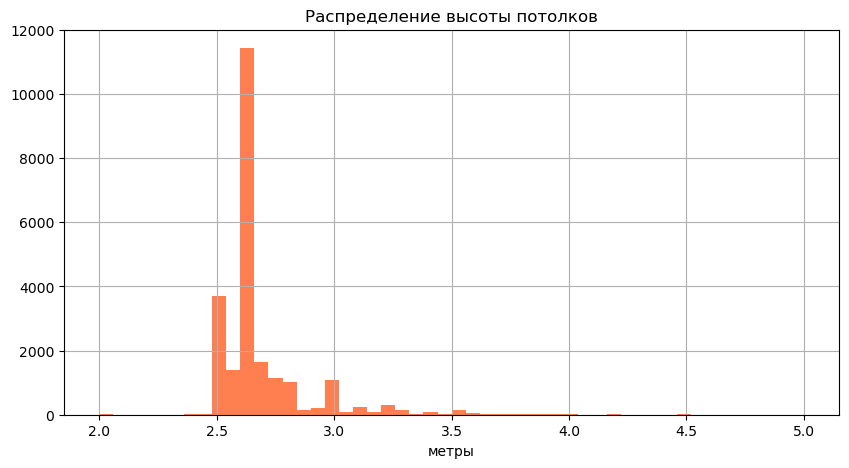

In [374]:
plt_hist(data_new, 'ceiling_height', (2,5), 50, \
         'метры', 'Распределение высоты потолков')

 - *Чаще всего встречаются квартиры с высотой потолко до 2,7 метров, что соответствует средним значениям высоты потолков жилых помещений*
 
 
- *Основной объем выборки попадает в область до 3,5 метров*
  



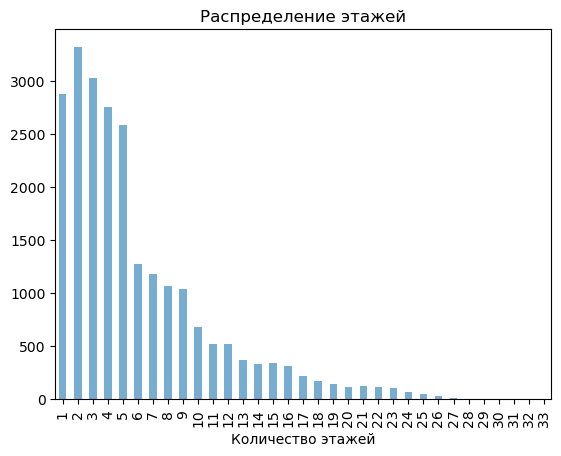

In [377]:
get_value(data_new, 'floor', 'count', 'Распределение этажей', 'Количество этажей')

*Чаще всего встречаются квартиры на этажах до 5-го, что является характерной особенностью Санкт-Петергбурга и области*  

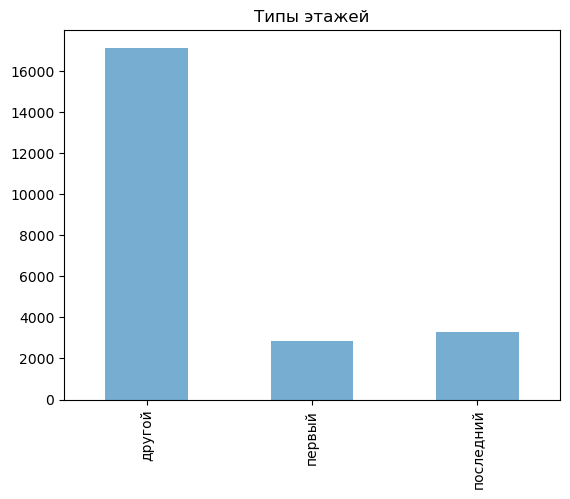

In [385]:
# построим гистограмму для категории этажей
get_value(data_new, 'floor_category', 'count', 'Типы этажей', '')

*Основная доля квартир попадает в категорию другой, что логично, так как охватывает большую долю выборки*

**Расстояния до центра и аэропорта будут сильно варьироваться для Санкт-Петербурга и области, поэтому рассмотрим их отдельно**

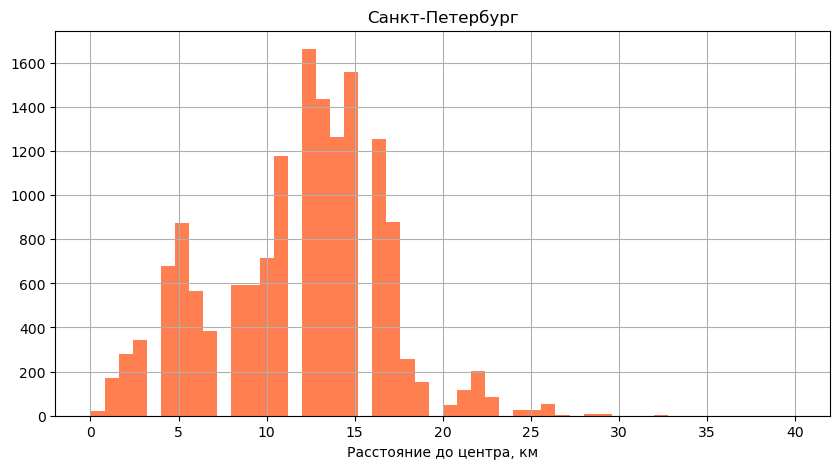

In [390]:
plt_hist(data_new.query('locality_name == "санкт-петербург"'), 'city_center', (0,40), 60, \
         'Расстояние до центра, км', 'Санкт-Петербург')

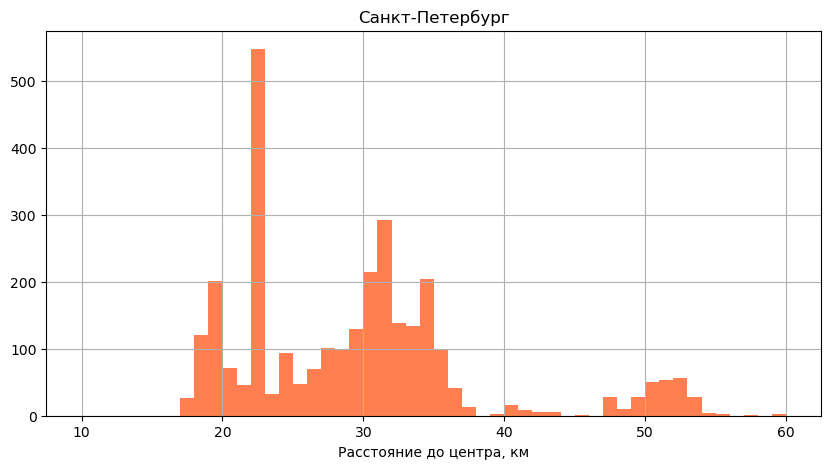

In [392]:
plt_hist(data_new.query('locality_name != "санкт-петербург"'), 'city_center', (10,60), 60, \
         'Расстояние до центра, км', 'Санкт-Петербург')

- *Для Санкт-Петербурга расстояние до центра укладывается в диапазон до 15 км, чаще всего встречаются объекты около 15 км* 
- *в области высокий пик около 24 км, что соответствует расстоянию до поселка Шушар. Пушкин, которые входят в состав города, также встречаются отдельные пики на расстояние 30-35 км*
- *график шумный, возможно, данные собирались по отдельным точкам*

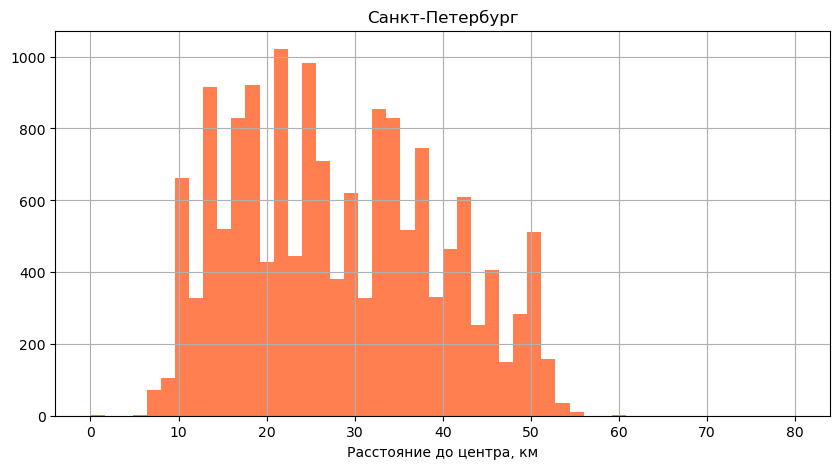

In [403]:
plt_hist(data_new.query('locality_name == "санкт-петербург"'), 'airports_nearest', (0,80), 60, \
         'Расстояние до аэропорта, км', 'Санкт-Петербург')

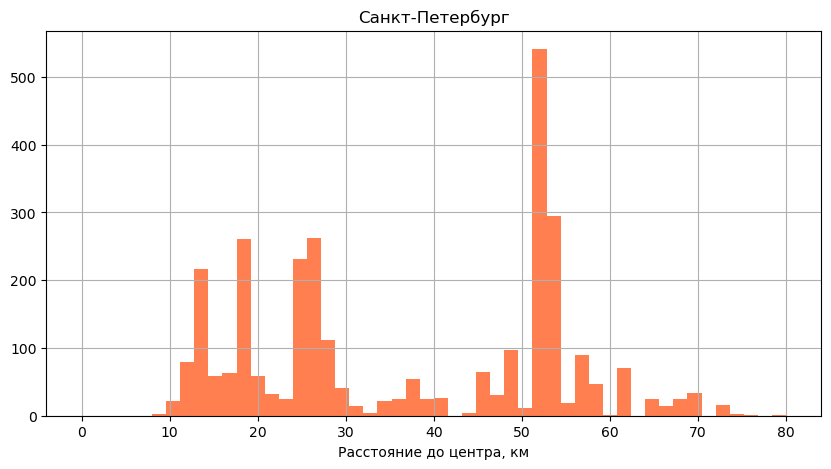

In [404]:
plt_hist(data_new.query('locality_name != "санкт-петербург"'), 'airports_nearest', (0,80), 60, \
         'Расстояние до аэропорта, км', 'Область')

- *В Санкт-Петербурге наибольшее количество квартир расположены на расстоянии от 10 до 35 км*
- *В области наибольшее количество квартир удалены от аэропорта более, чем на 50 км*
- *Есть характерные пики приблизительно на каждых 10 км, возможно, данные собирались по отсечкам в расстоянии*

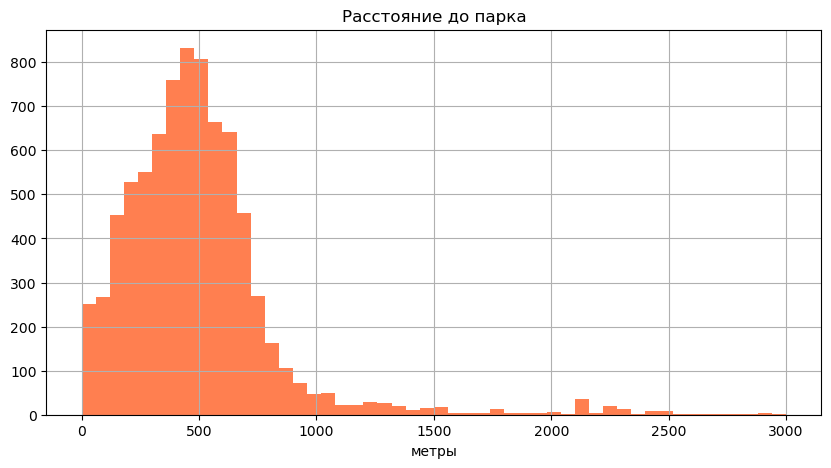

In [408]:
plt_hist(data_new, 'parks_nearest', (0,3000), 60, \
         'метры', 'Расстояние до парка')

*Для выборки с заполненными данными по этому параметру расстояние до парка составляет 3 км, скорее всего, для объявлений с пропущенными значениями нет парка в радиусе 3 км*

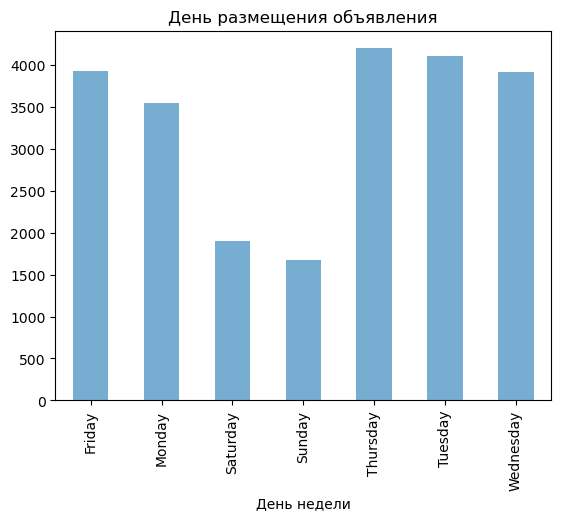

In [413]:
get_value(data_new, 'day', 'count', 'День размещения объявления', 'День недели')

*Наименьшие количество размещений объявлений характерно для выходных, наибольшее для середины недели*

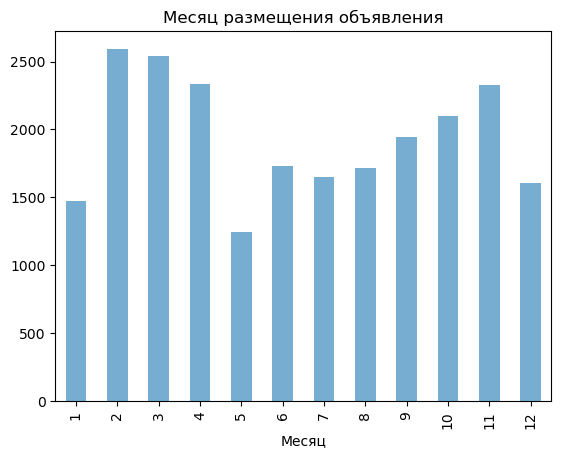

In [414]:
# построим гистограмму для месяца размещения объвления
get_value(data_new, 'month', 'count', 'Месяц размещения объявления', 'Месяц')

*Есть провалы в середине года, этот период соответствует периоду праздников и отпусков в России*

#### Оценка количества дней размещения объявления

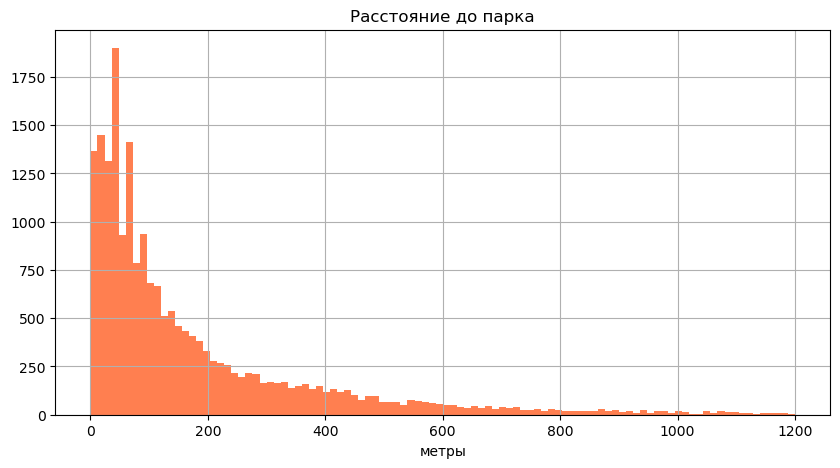

In [418]:
plt_hist(data_new, 'days_exposition', (0,1200), 100, \
         'метры', 'Расстояние до парка')

*Есть характерные пики в области 1 неделя, 45, 90, 120 дней. Скорее всего, это связано с окончанием срока подписки на объявление, после чего оно снимается. После этого срока значения распределены более равномерно. Медиана и среднее сильно отличаются, так как данные находятся в очень широком дипазоне*


*Чтобы исключить исключить влияние объявлений, снимающихся из-за подписки, предлагаю слишком короткими считать объявления меньше 45 дней, а долгими больше 230* 


#### Оценка влияния различных факторов на цену

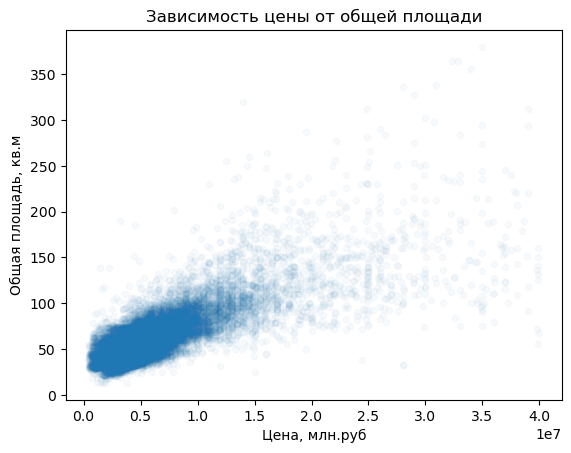

In [421]:
#Построим зависимость стоимости от общей площади квартиры
coef1=data_new['total_area'].corr(data_new['last_price'])
data_new.plot(x='last_price', y='total_area', kind='scatter', alpha=0.03)
plt.title('Зависимость цены от общей площади')
plt.xlabel('Цена, млн.руб')
plt.ylabel('Общая площадь, кв.м')
plt.show()


*На диаграмме рассеяния видно, что больший объем выборки укладывается в площадь до 120 кв.м и цену меньше 15 млн, приэтом зависимость в этом диапазоне линейная, при увеличении этих параметров, значения встречаются редко и слабее коррелируют между собой*

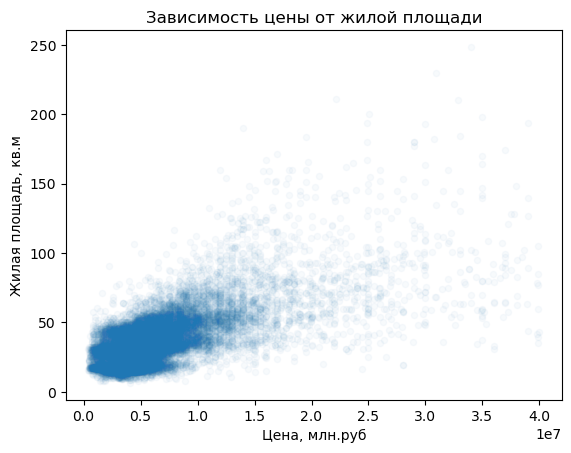

In [422]:
#Построим зависимость стоимости от жилой площади квартиры
coef2=data_new['living_area'].corr(data_new['last_price'])
data_new.plot(x='last_price', y='living_area', kind='scatter', alpha=0.03)
plt.title('Зависимость цены от жилой площади')
plt.xlabel('Цена, млн.руб')
plt.ylabel('Жилая площадь, кв.м')
plt.show()


*Из диаграммы рассеяния видно, что зависимость линейная при цене до 15 млн и площади приблизительно до 60 кв.м, при увеличении этих параметров корреляция падает*

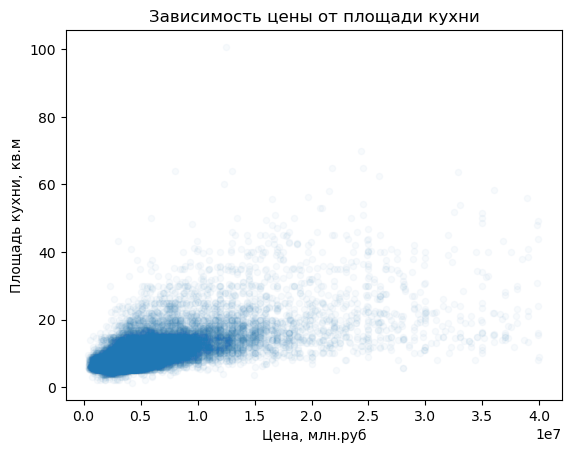

In [423]:
#Построим зависимость стоимости от площади кухни
coef3=data_new['kitchen_area'].corr(data_new['last_price'])
data_new.plot(x='last_price', y='kitchen_area', kind='scatter', alpha=0.03)
plt.title('Зависимость цены от площади кухни')
plt.xlabel('Цена, млн.руб')
plt.ylabel('Площадь кухни, кв.м')
plt.show()


*Зависимость между площадью кухни и ценой есть, но с увеличением параметров уменьшается быстрее, чем в случае с общей и жилой площадью. При цене квартиры до 10 млн появляются отдельные выбросы*

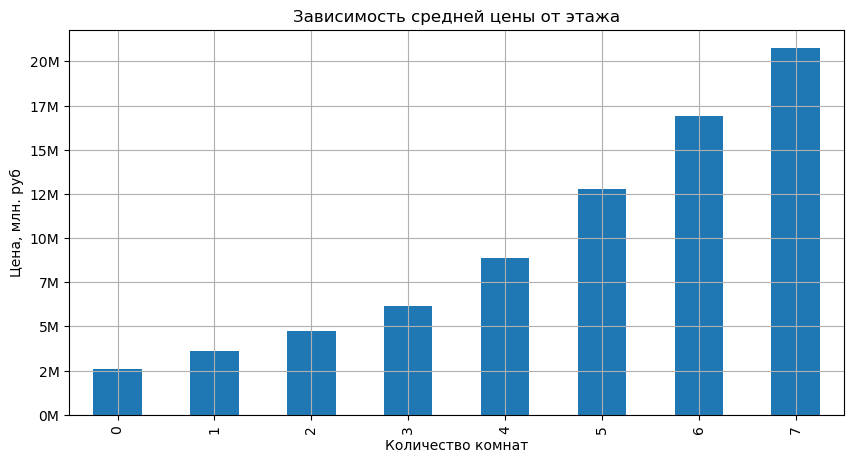

In [440]:
#Построим зависимость стоимости от количества комнат
fig, ax = plt.subplots(figsize=(10, 5)) 
ax=(
    data_new.
    pivot_table(index='rooms', values='last_price', aggfunc='median')
    .plot(y='last_price', kind='bar', grid=True, title='Зависимость средней цены от этажа', legend=False, ax=ax)
)
plt.xlabel('Количество комнат')
plt.ylabel('Цена, млн. руб')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{}'.format(int(x/1000000)) + 'M'))
plt.show()

*С увеличением количества комнат цена увеличивается, но нелинейно*

In [449]:
def plot_fig(index, values, func, xlabel, ylabel, title):
    fig, ax = plt.subplots(figsize=(10, 5)) 
    (
    data_new.
    pivot_table(index=index, values=values, aggfunc=func)
    .plot(y='last_price', style='o-', grid=True, title=title, ax=ax, legend=False)

    )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{}'.format(float(x/1000000)) + 'M'))

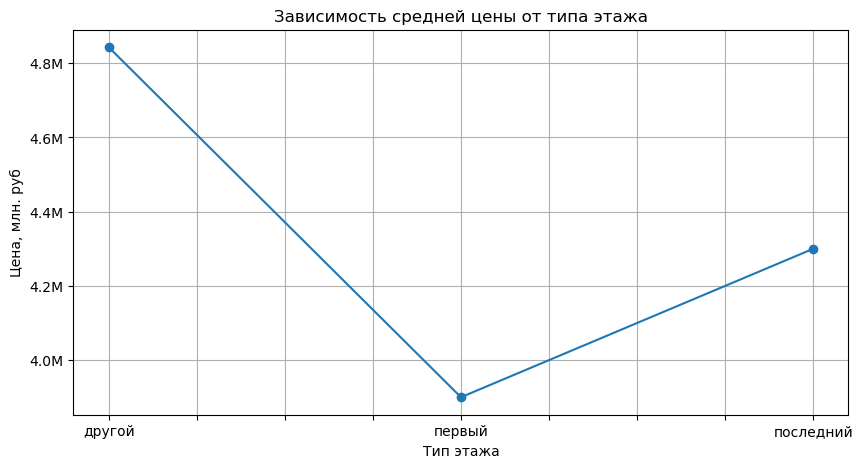

In [450]:
plot_fig('floor_category','last_price', 'median', 'Тип этажа', 'Цена, млн. руб', 'Зависимость средней цены от типа этажа')

*Квартиры, расположенные на первых и последних этажах, имеют меньшую среднюю стоимость, но зависимость незначительная*

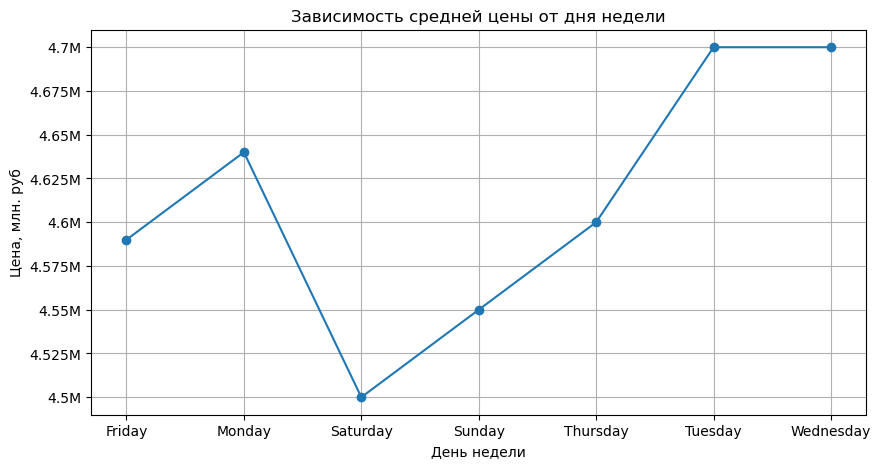

In [452]:
Построим зависимость цены от  
plot_fig('day','last_price', 'median', 'День недели', 'Цена, млн. руб', 'Зависимость средней цены от дня недели')

*Цена в выходные незначительно ниже будних дней, в выходные дни также меньше объявлений, поэтому выборка меньше*

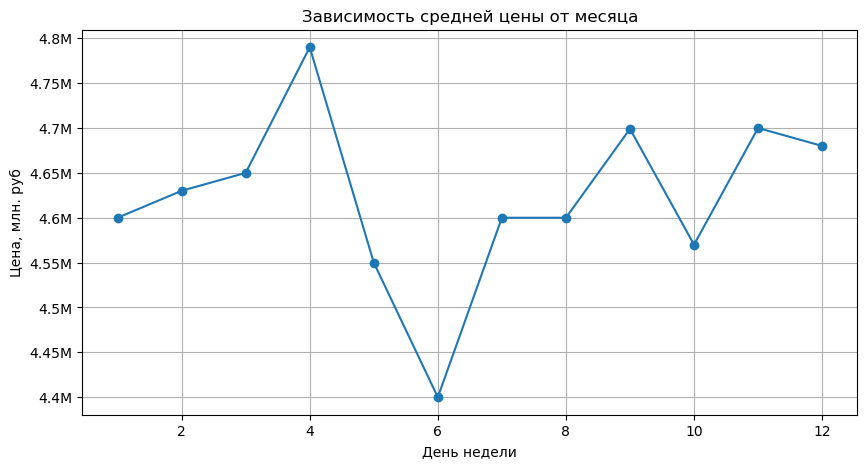

In [453]:
plot_fig('month','last_price', 'median', 'День недели', 'Цена, млн. руб', 'Зависимость средней цены от месяца')

*Месяц размещения объявления практически не влияет на цену* 

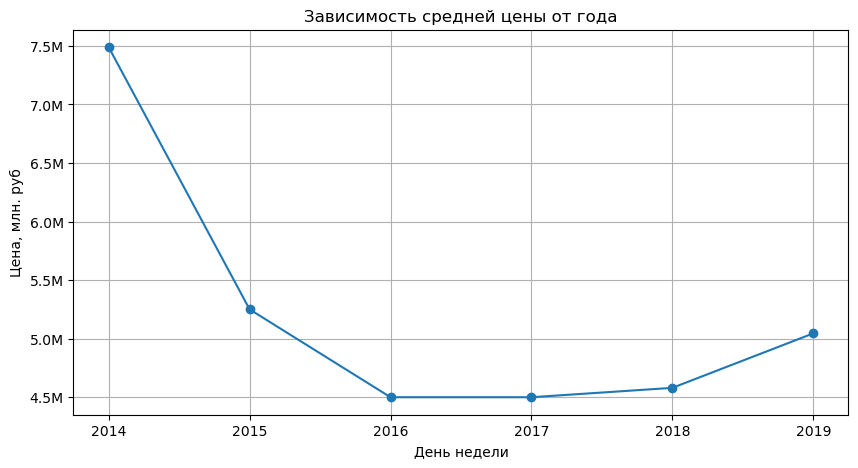

In [458]:
plot_fig('year','last_price', 'median', 'День недели', 'Цена, млн. руб', 'Зависимость средней цены от года')

Из графика видим, что цена значительно упала после 2014 года, а также продолжило падение в 2015, что нехарактерно для рынка недвижимости.
Псмотрим, какую долю объявлений составляют объявления до 2015 года 

In [468]:
print('Доля объявлений до 2015 году:', "{:.3%}".format(len(data_new.query('year==2014'))/len(data_new)))

Доля объявлений до 2015 году: 0.550%


*Объявления до 2015 года составляют менее 1%, таким образом эти данные нерепрезентативны. После 2015 года цена не изменяется и начинает расти после 2018 года*

*Произошло существенное падение цены с 2014 по 2016, в последующие годы цена немного возросла, в этой связи коэф корреляции отрицательный, но небольшой* 

<AxesSubplot:>

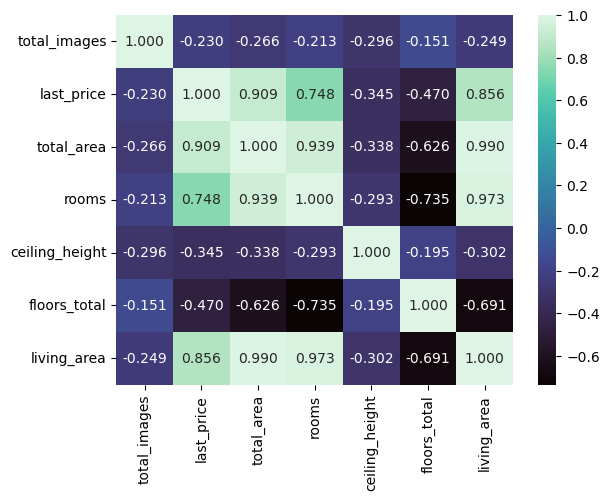

In [473]:
# Построим матрицу корреляции
corrMatrix =data_new.select_dtypes(include=np.number).iloc[:, :7].corr()
sns.heatmap(corrMatrix.corr(), annot=True, cmap='mako', fmt='.3f')

*Наибольшее влияние на цену из представленных параметров оказывает площадь квартиры, при этом необязательно, что она увеличивается с увеличением количества комнат, зависимость цены и количества комнат существенно ниже.
Далее по убыванию на цену влияет жилая площадь и площадь кухни, год размещения, наименьшее влияние оказывает день и месяц размещения объявления.*

#### Расчет средней цены одного квадратного метра

In [219]:
#Найдем 10 населённых пунктах с наибольшим числом объявлений
data_price=data_new.pivot_table(index='locality_name', values='total_area', aggfunc='count').sort_values(by='total_area', ascending=False)
data_price.columns=['count']
data_price=data_price[:10]
#Найдем цену 1 квадратного метра
data_new['sqr_price']=data_new['last_price']/data_new['total_area']
#объединим таблицы и посчитаем среднее значение для каждого населенного пункта
data_sqr=(
    data_new.
    query('locality_name in @data_price.index')
    .pivot_table(index='locality_name', values='sqr_price', aggfunc='mean')

)
data_price['sqr_price']=data_sqr['sqr_price']
data_price.sort_values(by='sqr_price', ascending=False)


,count,sqr_price
locality_name,,
санкт-петербург,15227,111232.668189
пушкин,364,103177.928014
деревня кудрово,288,92282.666094
поселок парголово,322,90165.939334
поселок мурино,520,84852.198665
поселок шушары,433,78339.225838
колпино,335,75408.562836
гатчина,302,68636.425344
всеволожск,380,68599.105615


*Наиболее высокая цена за кв.м. ожидаемо в Санкт-Петербурге, остальные населенные пункты расположены близко к нему, скорее всего, высокая цена связана с расположением* 

#### Расчет средней цены кажого км

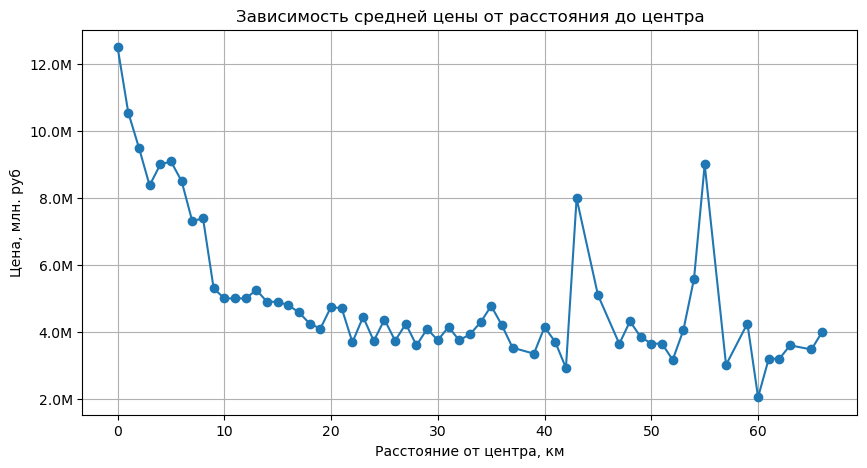

In [479]:
plot_fig('city_center','last_price', 'median', \
         'Расстояние от центра, км', 'Цена, млн. руб', 'Зависимость средней цены от расстояния до центра')

*Цена за каждый км от центра существенно падает, первые 10 снижают цену практически в два раза, однако есть аномальные увеличения цены на определенных расстояних. Скорее всего, это связано с районом, в котором данные квартиры расположены*

### Общий вывод
**Для анализа данных на рынке недвижимости были проведены следующие этапы**:

**В результате предобработки данных были исключены объвления**:


- пустые ячейки заменили нулевыми значениями там, где это было возможно (количество балконов, парков, прудов)
- пустые ячейки в площади кухни и жилой площади заменили средними значеними, при условии, что их сумма не больше заданной, строки, не соответстующие данному условию удалили
- строки с пустыми значениями общего количества этажей были удалены, для корректных расчетов в последующем анализе
- для заполнения пропусков в населенных пунктах были вычислены названия населенных пунктов по расстоянию от центра по названию населенного пункта были вычислены средние значения расстояний до центра и аэропорта и заполнены пропущенные значения там, где данные были представлены
- с аномально высокой ценой (>40 млн) и площадью(>400 кв.м): данные квартиры относятся к элитной недвижимости, но их выборка очень мала для адекватного анализа
- маленькой жилой площадью(<5 кв.м): в таких квартирах общая площадь была намного выше жилой, что, скорее всего указывает на некорректность размещенных данных) и кухней (<1.3 кв.м): такая площадь нереальна для кухни 
- очень высокими потолками (>5 м): максимальная высота потолков в жилых помещения Санкт-Петербурге 5 м, судя по данным из открытых источников, и низкими потолками (<2.5 м): ниже значения не разрешены по санитарным нормам
- с большим количеством комнат (>7), также относятся к элитной недвижимостью
- с суммой площади кухни и жилой зоны больше общей: в таких объявлениях, скорее всего, указаны некорректные данные


**Заменили формат данных**:


- день размещения объявления- заменили тип  на дату для дальнейшей работой со значениями
- строковые тип заменили на булев, так как он занимает меньший объем
- floors_total balcony, parks_around3000, ponds_around3000, days_exposition - заменим на int, так как эти данные могут принимать только целые значения и в таком формате занимают меньший объем


**В результате анализа данных было установлено следующее**:

 - наиболее часто встречающаяся площадь объектов в объявлениях для области ниже, чем для Санкт-Петербурга, основной объем выборки укладывается в меньший диапазон 
 - средняя цена квартир в области ниже, диапазон цен значительно отличается, для области основной объем данных укладывается в диапазон до 10 млн. руб, тогда как для Санкт-Петербурга до 20 млн 
 - в области доля 1х квартир выше, чем 2х и 3х комнатных, в Санкт-Петерберге наиболее часто встречаются двухкомнатные квартиры, при этом доля 3х комнатных квартир в Санкт-Петербурга выше
 - большинство квартир расположено в этажах до 5-го, что связано с небольшой этажностью построек в Санкт-Петербурге и области
 - в Санкт-Петербурге основная доля квартир расположена на расстоянии до 20 км от центра, в области наиболее часто встречаются предложения на расстоянии около 20, 30 км. Однако нужно учесть, что данные формировались автоматически и в них много пропусков. Для более корректной оценки этого параметра нужно уточнить, как собиралась эта информация и почему возникали пропуски

- Наименьшие количество размещений объявлений характерно для выходных, наибольшее для середины недели
- Есть провалы в количестве объявлений середине года (с мая и по август), этот период соответствует периоду праздников и отпусков в России, наибольшая активность в феврале-марте

- В выборке присутствуют объявления, в которых длительность размещения составляет более одного года или меньше, при этом 75% объявлений снимается через 230 дней. Имеются выдающиеся пики на определенных отрезках 1 неделя, 45, 90, 120 дней. Скорее всего, это связано с окончанием срока подписки на объявление, после чего оно снимается. После этого срока значения распределены более равномерно. Медиана и среднее сильно отличаются, так как данные находятся в очень широком дипазоне. Для более корректной оценки этого параметра необходимо уточнение информации по формированию этих данных, объявления со значениями до 14 дней и 230 дней предлагается считать слишком короткими и длинными соответственно на этом этапе обработки данных

**В результате анализа зависимости цены от различных факторов было установлено следующее**:

- Наибольшее влияние на цену из представленных параметров оказывает площадь квартиры, при этом необязательно, что она увеличивается с увеличением количества комнат, зависимость цены и количества комнат существенно ниже. 
- Далее по убыванию на цену влияет жилая площадь и площадь кухни, год размещения, наименьшее влияние оказывает день и месяц размещения объявления
- Тип этажа несущественно влияет на цену, для первого и последнего этажа немного ниже других этажей, самая низкая цена у первого
- Отмечено, что с увеличением значений параметров корреляция между ними и ценой снижается, при оценке зависимости значений, выходящих за основной объем выборки, видим на графиках существенный разброс данных 
- С 2014 по 2016 наблюдалось серьезное падение цены на квартиры, с 2017 начался небольшой рост, при этом день и месяц размещения объявления практически не влияет на цену
- Наиболее высокая цена за квадратный метр в Санкт-Петербурге, далее по убыванию идут населенные пункты, расположенные близко к нему
- Первые 10 км от центра снижают стоимость квартиры почти в два раза, при этом есть отдельные пик на расстояние 27 км, возмжно, там расположен один из элитных районов

**Рекомендации к дальнейшему анализу данных**:

- Изучить выборку данных для среднестатистических квартир, без выбивающихся значений элитного жилья
- Изучить рынок элитного жилья отдельно, но для данного анализа в представленной выборке мало данных, необходимо собрать больше данных на основании диапазонов, установленных в текущем анализе
- Установить причину и устранить ошибки в автоматическом сборе данных
- Разделить причину снятия объявления по категориям 
- При оценке зависимости цены от расположения помещения нужно учитывать не только расстояние, но и район, в котором оно находится